# ML & Web scraping

### Data set used for ML part was created during Web Scrapping process.<br>
### For ML PART: code is as a MARKDOWN to keep data and results as they are shown in the report. Please load attached file created as a result of web scrapping.
### For Programming: please remove mardown and use web scrapping code.

In [166]:
# loading libraries
import requests
from bs4 import BeautifulSoup 
import pandas as pd
import re
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from datetime import date
from datetime import datetime
from genderize import Genderize
import nltk
from nltk.corpus import stopwords
from textblob import TextBlob

In [167]:
# # getting a User-Agent from https://httpbin.org/get
# headers = { "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/105.0.0.0 Safari/537.36 Edg/105.0.1343.27", "Accept-Encoding":"gzip, deflate", "Accept":"text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8", "DNT":"1","Connection":"close", "Upgrade-Insecure-Requests":"1"}


In [168]:
# baseurl = 'https://www.property.ie/property-for-sale/dublin/price_0-950000/'

In [169]:
productlinks = []
for x in range(1,120):
    r = requests.get(f'https://www.property.ie/property-for-sale/dublin/price_0-950000/p_{x}/')
    soup = BeautifulSoup(r.content, 'html.parser')
    productlist = soup.find_all('div', class_='search_result')

    for item in productlist:
        link = item.find('a', href=True)
        if link:
            productlinks.append(link['href'])

print(productlinks)

['https://www.property.ie/property-for-sale/69-Kilbarron-Park-Kilmore-Kilmore-Dublin-5/14126974/', 'https://www.property.ie/property-for-sale/67-Park-Drive-Avenue-Castleknock-Castleknock-Dublin-15/16019228/', 'https://www.property.ie/property-for-sale/109-Clonliffe-Avenue-Dublin-3/15429344/', 'https://www.property.ie/property-for-sale/2a-Ballykea-Close-Ballykea-Skerries-Co-Dublin/16283509/', 'https://www.property.ie/property-for-sale/77-Kill-Avenue-Dun-Laoghaire-Co-Dublin/15951547/', 'https://www.property.ie/property-for-sale/13a-Hilltown-Lawn-Swords-Co-Dublin/15818059/', 'https://www.property.ie/property-for-sale/Tobersool-Lane-Balbriggan-Co-Dublin/14245866/', 'https://www.property.ie/property-for-sale/16-Achill-House-Custom-House-Square-IFSC-Dublin-1/16035433/', 'https://www.property.ie/property-for-sale/7-Brennanstown-Court-Brennanstown-Cabinteely-Dublin-18/15812248/', 'https://www.property.ie/property-for-sale/19-Abby-Well-Chapel-Road-Malahide-Co-Dublin/8594228/', 'https://www.prop

In [170]:
# House = []
# for link in productlinks:
#     r = requests.get(link, headers=headers)
#     soup = BeautifulSoup(r.content, 'lxml')
    
# # address
#     address = soup.find('h1', style = 'clear: left').text.strip()
    
    
# # pulling the data
#     na = soup.find("div", id="searchmoreinfo_summary")
#     name = na.get_text(strip=True)
    
    
# # extract price
#     price_match = re.search(r'€([\d,]+)',name)
#     if price_match:
#         price = price_match.group(1)
#     else:
#         price = None

# # pulling the number of bedrooms and bathrooms
#     bedrooms_match = re.search(r'(\d+) Bedrooms', name)
#     if bedrooms_match:
#         bedrooms = bedrooms_match.group(1)
#     else:
#         bedrooms = None

#     bathrooms_match = re.search(r'(\d+) Bathrooms', name)
#     if bathrooms_match:
#         bathrooms = bathrooms_match.group(1)
#     else:
#         bathrooms = None

# # extracting house type
#     house_type_match = re.search(r'(\w+ House)', name)
#     if house_type_match:
#         house_type = str(house_type_match.group(1))
#     else:
#         house_type = None
        
    
#     if house_type is not None:
#         house_type.startswith('000')
#         house_type = house_type.lstrip('0')
#     else:
#         house_type = None


# # creating a dictionary with the extracted information
#     info = {'Address':address,
#         'Price': price,
#         'Bedrooms': bedrooms,
#         'Bathrooms': bathrooms,
#         'House Type': house_type
# }
#     House.append(info)
#     print(info)

{'Address': '69 Kilbarron Park, Kilmore, Kilmore, Dublin 5', 'Price': '340,000', 'Bedrooms': '3', 'Bathrooms': None, 'House Type': 'Terraced House'}
{'Address': '67 Park Drive Avenue, Castleknock, Castleknock, Dublin 15', 'Price': '550,000', 'Bedrooms': '3', 'Bathrooms': '2', 'House Type': 'Terraced House'}
{'Address': '109 Clonliffe Avenue, Dublin 3', 'Price': '310,000', 'Bedrooms': '2', 'Bathrooms': None, 'House Type': 'Terraced House'}
{'Address': '2a Ballykea Close, Ballykea, Skerries, Co. Dublin', 'Price': '775,000', 'Bedrooms': '4', 'Bathrooms': '3', 'House Type': 'Detached House'}
{'Address': '77 Kill Avenue, Dun Laoghaire, Co. Dublin', 'Price': '795,000', 'Bedrooms': '4', 'Bathrooms': '5', 'House Type': 'Detached House'}
{'Address': '13a Hilltown Lawn, Swords, Co. Dublin', 'Price': '449,000', 'Bedrooms': '3', 'Bathrooms': '3', 'House Type': 'Detached House'}
{'Address': 'Tobersool Lane, Balbriggan, Co. Dublin', 'Price': '545,000', 'Bedrooms': '4', 'Bathrooms': '2', 'House Type'

In [ ]:
# # saving data as dataFrame
# df_Dublin = pd.DataFrame(House)

In [ ]:
# saving file into and excel file
# df_Dublin.to_excel('C:\\ESTERA\\CA2\\data sets - IRL\\Dublin_Houses.xlsx', index=False)

In [2]:
# loading data set
df_Dublin = pd.read_excel('C:\\ESTERA\\CA2\\data sets - IRL\\Dublin_Houses.xlsx')

df_Dublin.head()

,Address,Price,Bedrooms,Bathrooms,House Type
0,"67 Park Drive Avenue, Castleknock, Castleknock...","550,000",3.0,2.0,Terraced House
1,"109 Clonliffe Avenue, Dublin 3","310,000",2.0,NaN,Terraced House
2,"2a Ballykea Close, Ballykea, Skerries, Co. Dublin","775,000",4.0,3.0,Detached House
3,"77 Kill Avenue, Dun Laoghaire, Co. Dublin","795,000",4.0,5.0,Detached House
4,"13a Hilltown Lawn, Swords, Co. Dublin","449,000",3.0,3.0,Detached House


In [3]:
df_Dublin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1101 entries, 0 to 1100
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Address     1101 non-null   object 
 1   Price       1101 non-null   object 
 2   Bedrooms    975 non-null    float64
 3   Bathrooms   619 non-null    float64
 4   House Type  693 non-null    object 
dtypes: float64(2), object(3)
memory usage: 43.1+ KB


In [4]:
# splitting the address data 
split_address = df_Dublin['Address'].str.rsplit(', ', n=2, expand=True)
df_Dublin[['District', 'Area', 'Street']] = split_address.iloc[:, ::-1]
df_Dublin.head()

,Address,Price,Bedrooms,Bathrooms,House Type,District,Area,Street
0,"67 Park Drive Avenue, Castleknock, Castleknock...","550,000",3.0,2.0,Terraced House,Dublin 15,Castleknock,"67 Park Drive Avenue, Castleknock"
1,"109 Clonliffe Avenue, Dublin 3","310,000",2.0,NaN,Terraced House,None,Dublin 3,109 Clonliffe Avenue
2,"2a Ballykea Close, Ballykea, Skerries, Co. Dublin","775,000",4.0,3.0,Detached House,Co. Dublin,Skerries,"2a Ballykea Close, Ballykea"
3,"77 Kill Avenue, Dun Laoghaire, Co. Dublin","795,000",4.0,5.0,Detached House,Co. Dublin,Dun Laoghaire,77 Kill Avenue
4,"13a Hilltown Lawn, Swords, Co. Dublin","449,000",3.0,3.0,Detached House,Co. Dublin,Swords,13a Hilltown Lawn


In [5]:
# moving all values from Area column to District column if there is word 'Dublin' in it
df_Dublin.loc[df_Dublin['Area'].str.contains(r'\bDublin\b', na=False), 'District'] = df_Dublin['Area']
df_Dublin['Area'] = df_Dublin['Area'].str.replace(r'\bDublin\b', '')
df_Dublin.head()

C:\Users\ester\AppData\Local\Temp\ipykernel_9100\2206455085.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df_Dublin['Area'] = df_Dublin['Area'].str.replace(r'\bDublin\b', '')


,Address,Price,Bedrooms,Bathrooms,House Type,District,Area,Street
0,"67 Park Drive Avenue, Castleknock, Castleknock...","550,000",3.0,2.0,Terraced House,Dublin 15,Castleknock,"67 Park Drive Avenue, Castleknock"
1,"109 Clonliffe Avenue, Dublin 3","310,000",2.0,NaN,Terraced House,Dublin 3,3,109 Clonliffe Avenue
2,"2a Ballykea Close, Ballykea, Skerries, Co. Dublin","775,000",4.0,3.0,Detached House,Co. Dublin,Skerries,"2a Ballykea Close, Ballykea"
3,"77 Kill Avenue, Dun Laoghaire, Co. Dublin","795,000",4.0,5.0,Detached House,Co. Dublin,Dun Laoghaire,77 Kill Avenue
4,"13a Hilltown Lawn, Swords, Co. Dublin","449,000",3.0,3.0,Detached House,Co. Dublin,Swords,13a Hilltown Lawn


In [6]:
# dropping unnecessary columns
df_Dublin.drop(columns=['Address', 'Area', 'Street'], inplace=True)

In [7]:
# dropping all none values
df_Dublin = df_Dublin.dropna()

In [8]:
# removing "," sign
df_Dublin['Price'] = df_Dublin['Price'].str.replace(',', '')

In [9]:
# checking column types
df_Dublin.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 430 entries, 0 to 1099
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Price       430 non-null    object 
 1   Bedrooms    430 non-null    float64
 2   Bathrooms   430 non-null    float64
 3   House Type  430 non-null    object 
 4   District    430 non-null    object 
dtypes: float64(2), object(3)
memory usage: 20.2+ KB


In [10]:
# converting object columns to int
columns_to_convert = ['Price', 'Bedrooms', 'Bathrooms']
df_Dublin.loc[:, columns_to_convert] = df_Dublin.loc[:, columns_to_convert].astype(int)

In [11]:
# checking how many unique types of house
df_Dublin['House Type'].unique()

array(['Terraced House', 'Detached House', 'Terrace House',
       '950Terraced House', '950Detached House'], dtype=object)

In [12]:
# correcting errors withing 'House Type' column
Terraced = ['Terraced House','950Terraced House']
df_Dublin['House Type'] = df_Dublin['House Type'].replace(Terraced, 'Terrace House')
df_Dublin['House Type'] = df_Dublin['House Type'].replace('950Detached House', 'Detached House')
df_Dublin['House Type'].unique()

array(['Terrace House', 'Detached House'], dtype=object)

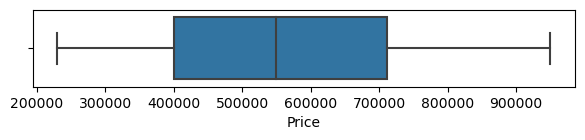

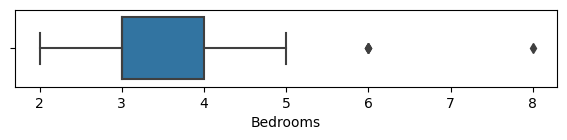

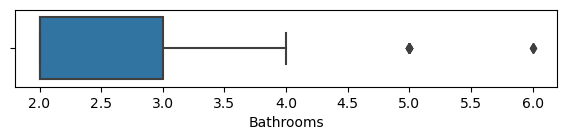

In [13]:
# creating boxplots to visualise data

import matplotlib.pyplot as plt

# selecting only non-object columns
numeric_columns = df_Dublin.select_dtypes(exclude='object').columns


for column in df_Dublin[numeric_columns]:
        plt.figure(figsize=(7,1))
        sns.boxplot(data=df_Dublin[numeric_columns], x=column)
       # plt.show()

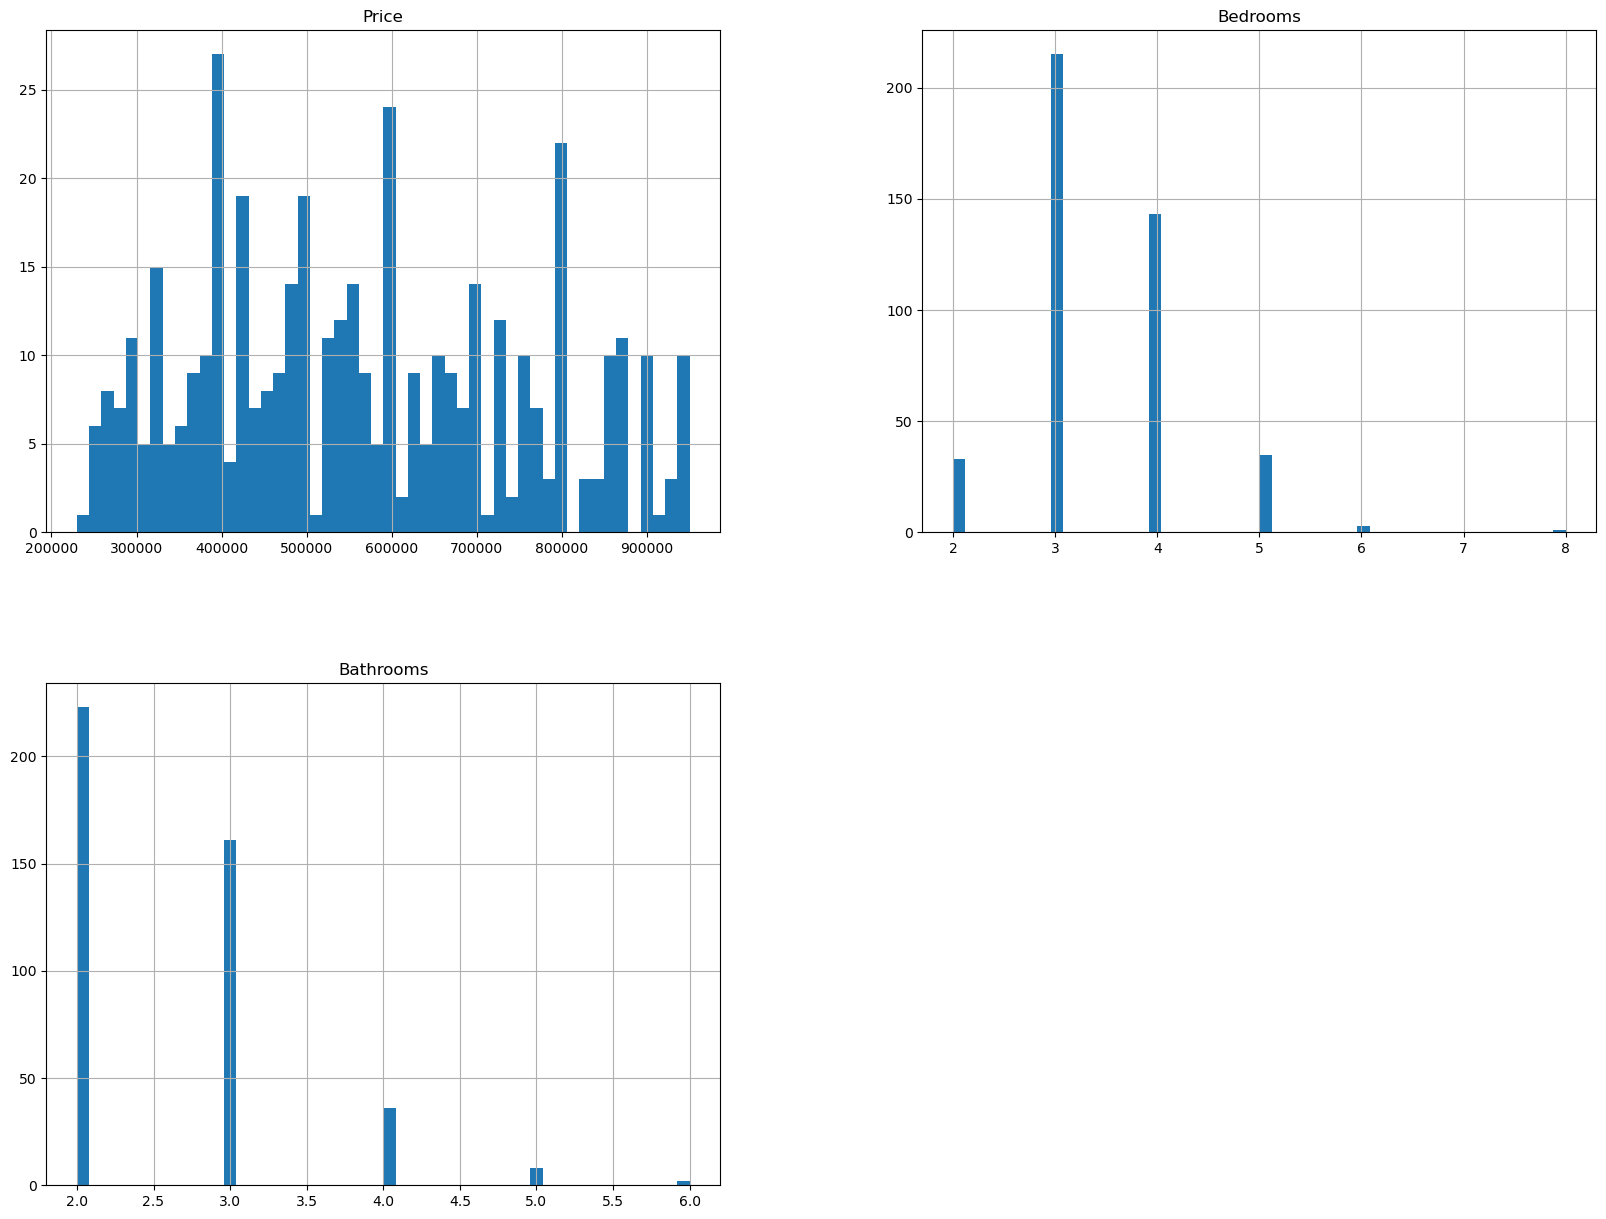

In [14]:
# creating a histograms
df_Dublin.hist(bins=50, figsize=(20,15))
plt.show()

## 2. Binary Classification
### 2.1. Preparing data

In [15]:
# getting dummies for 'House Type' column
df_Dublin = pd.get_dummies(df_Dublin, columns=['House Type'])
df_Dublin.head()

,Price,Bedrooms,Bathrooms,District,House Type_Detached House,House Type_Terrace House
0,550000,3,2,Dublin 15,0,1
2,775000,4,3,Co. Dublin,1,0
3,795000,4,5,Co. Dublin,1,0
4,449000,3,3,Co. Dublin,1,0
5,545000,4,2,Co. Dublin,1,0


In [16]:
# modifing 'District' column
df_Dublin['District'] = df_Dublin['District'].apply(lambda x: 'County' if 'Co.' in x else 'Dublin' if 'Dublin' in x else x)
df_Dublin.head()

,Price,Bedrooms,Bathrooms,District,House Type_Detached House,House Type_Terrace House
0,550000,3,2,Dublin,0,1
2,775000,4,3,County,1,0
3,795000,4,5,County,1,0
4,449000,3,3,County,1,0
5,545000,4,2,County,1,0


In [17]:
df_Dublin['Price'].describe()

count       430.000000
mean     564768.476744
std      189067.267221
min      230000.000000
25%      400000.000000
50%      549975.000000
75%      711000.000000
max      950000.000000
Name: Price, dtype: float64

In [18]:
# creating a price rangne groups
start_value = 230000
end_value = 950000
num_groups = 5  # Number of groups to create

# calculating the step size to evenly divide the range
step_size = (end_value - start_value) / num_groups

# defining the range labels for each group
range_labels = [f"{start_value + i * step_size}-{start_value + (i + 1) * step_size}" for i in range(num_groups)]

# creating the groups
groups = pd.cut(df_Dublin['Price'], bins=num_groups, labels=False)

# creating separate columns for each group using get_dummies and name the columns
group_columns = pd.get_dummies(groups, prefix='Price_Group')
group_columns.columns = ['Price_Group_' + range_labels[i] for i in range(num_groups)]

# concatenating the group columns with the original DataFrame
df_Dublin = pd.concat([df_Dublin, group_columns], axis=1)

df_Dublin.head()

,Price,Bedrooms,Bathrooms,District,House Type_Detached House,House Type_Terrace House,Price_Group_230000.0-374000.0,Price_Group_374000.0-518000.0,Price_Group_518000.0-662000.0,Price_Group_662000.0-806000.0,Price_Group_806000.0-950000.0
0,550000,3,2,Dublin,0,1,0,0,1,0,0
2,775000,4,3,County,1,0,0,0,0,1,0
3,795000,4,5,County,1,0,0,0,0,1,0
4,449000,3,3,County,1,0,0,1,0,0,0
5,545000,4,2,County,1,0,0,0,1,0,0


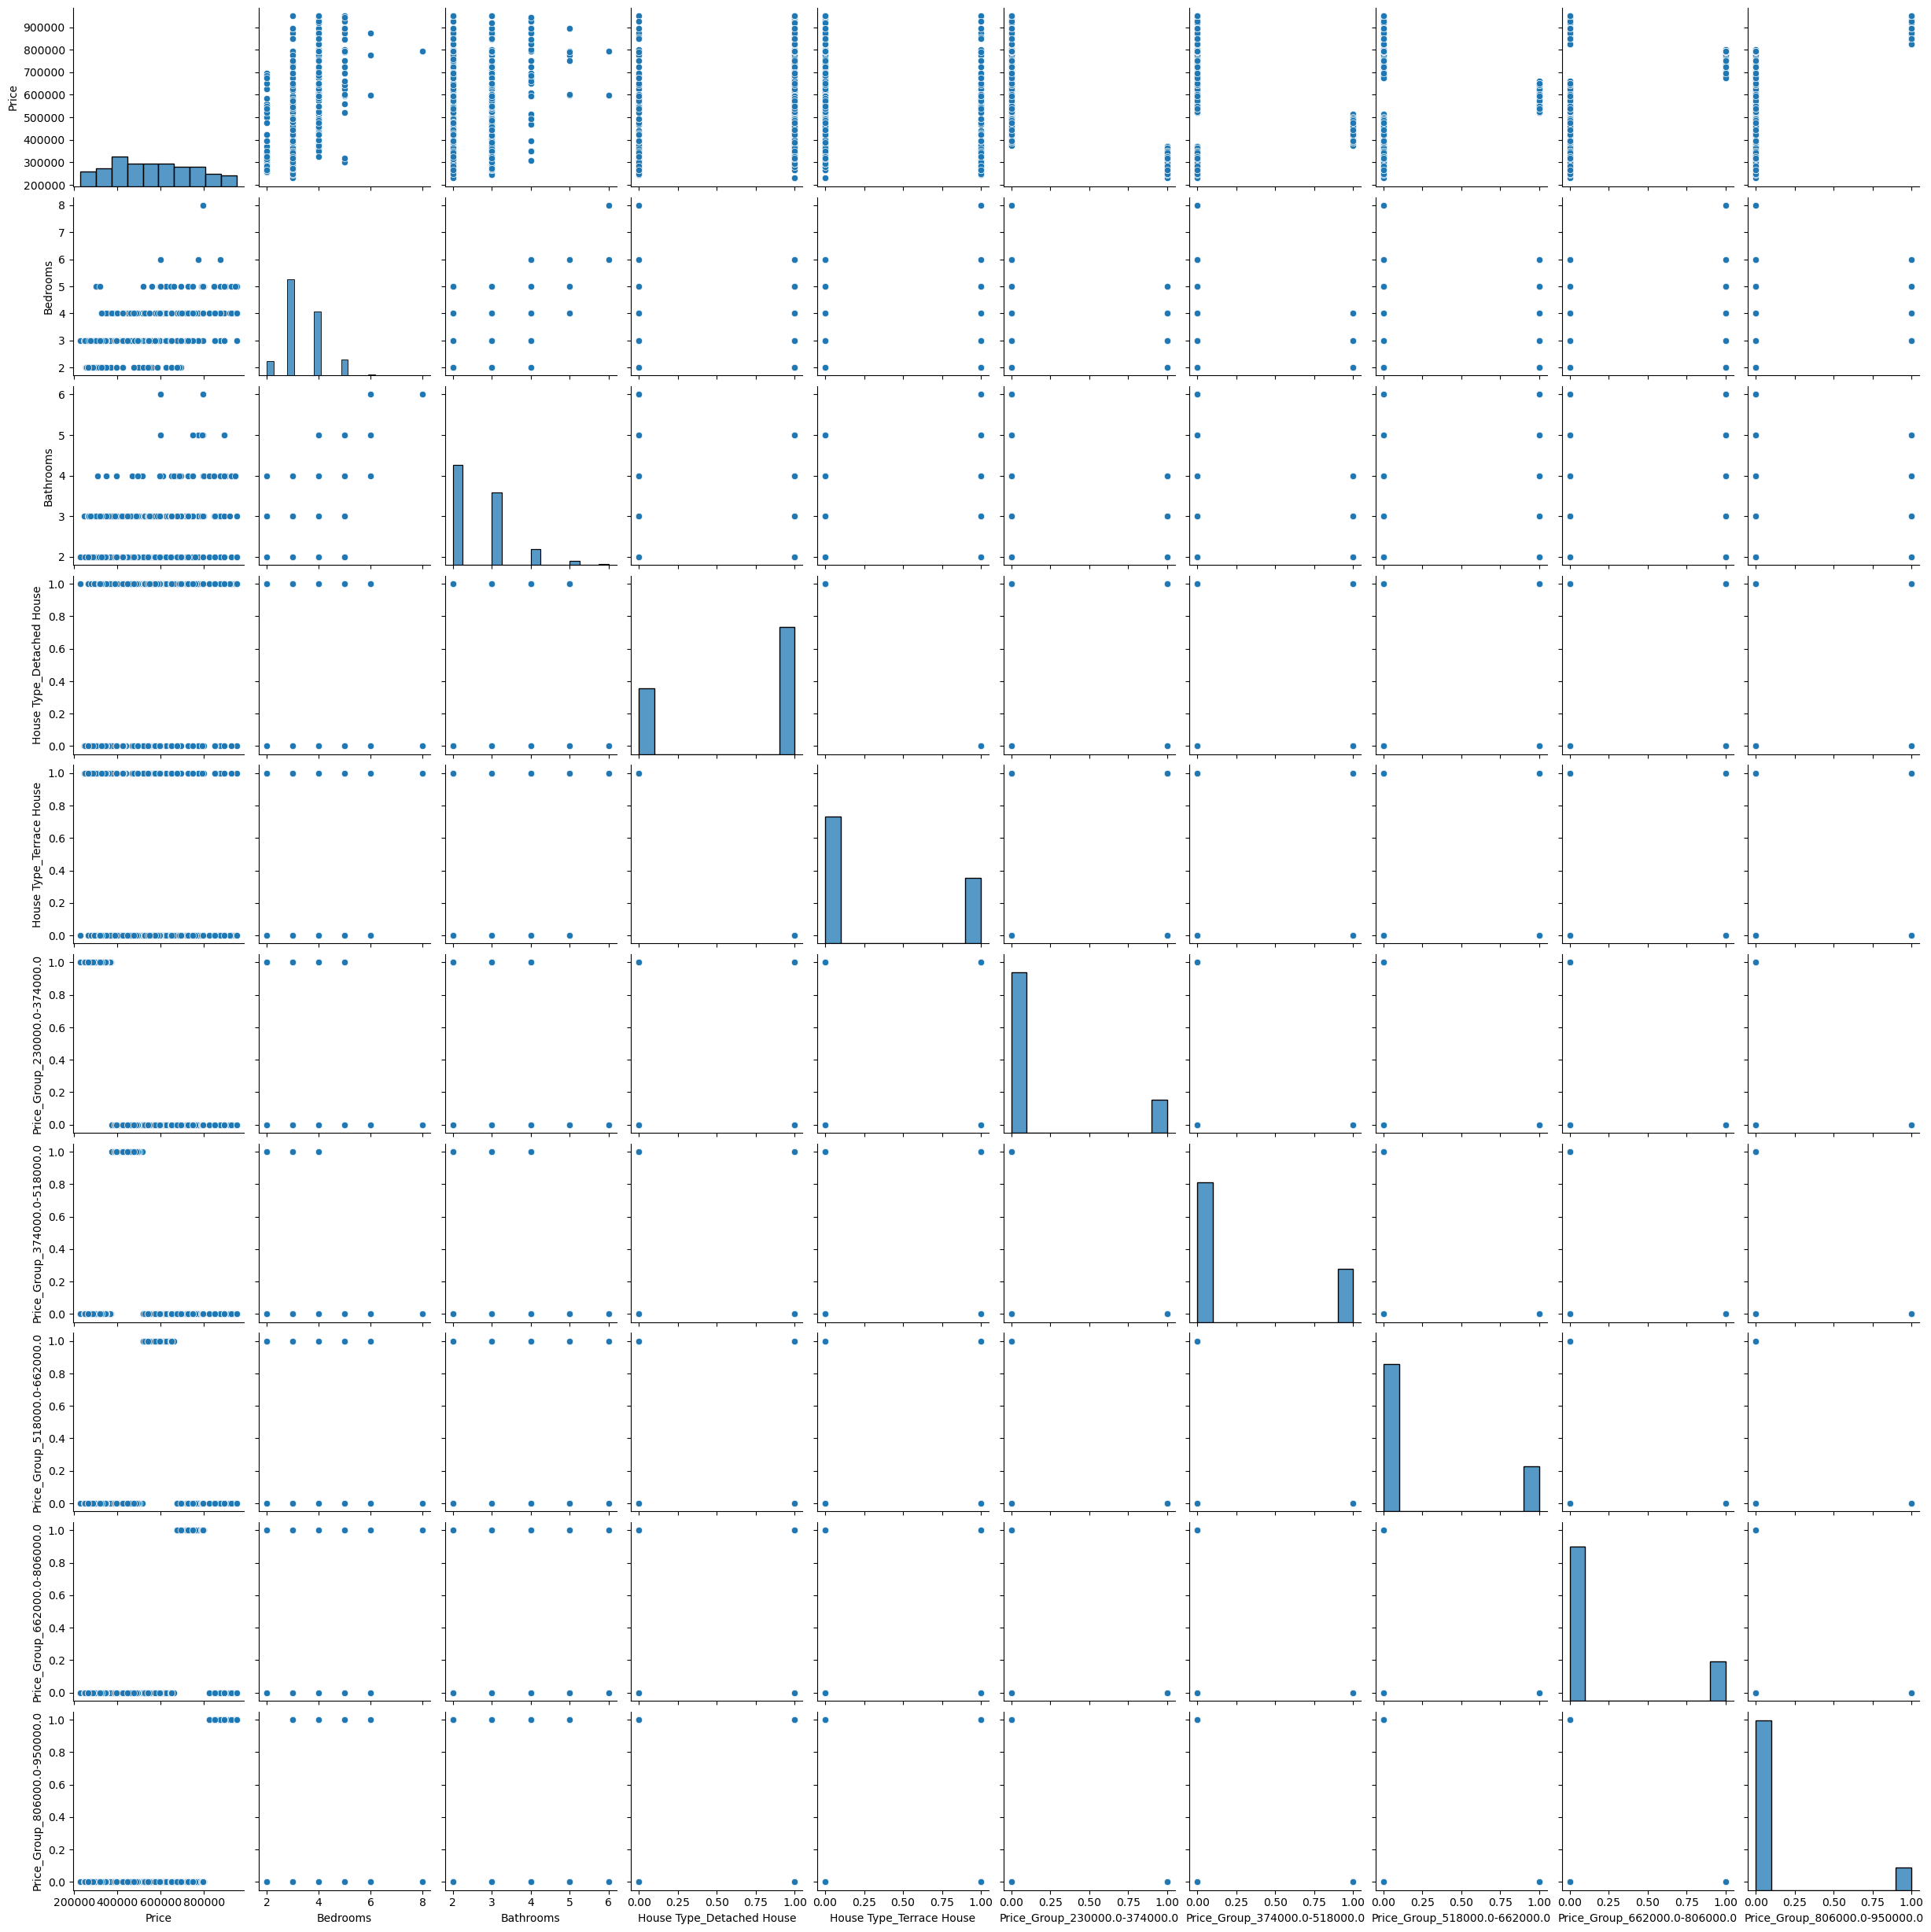

In [19]:
# creating a pair plot to see type of relationships between variables

# selecting only numerical columns
numerical_cols = df_Dublin.select_dtypes(include='number')

sns.pairplot(numerical_cols)
plt.show()

In [20]:
df_Dublin.drop('Price', axis=1, inplace=True)

In [21]:
df_Dublin.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 430 entries, 0 to 1099
Data columns (total 10 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   Bedrooms                       430 non-null    int32 
 1   Bathrooms                      430 non-null    int32 
 2   District                       430 non-null    object
 3   House Type_Detached House      430 non-null    uint8 
 4   House Type_Terrace House       430 non-null    uint8 
 5   Price_Group_230000.0-374000.0  430 non-null    uint8 
 6   Price_Group_374000.0-518000.0  430 non-null    uint8 
 7   Price_Group_518000.0-662000.0  430 non-null    uint8 
 8   Price_Group_662000.0-806000.0  430 non-null    uint8 
 9   Price_Group_806000.0-950000.0  430 non-null    uint8 
dtypes: int32(2), object(1), uint8(7)
memory usage: 29.2+ KB


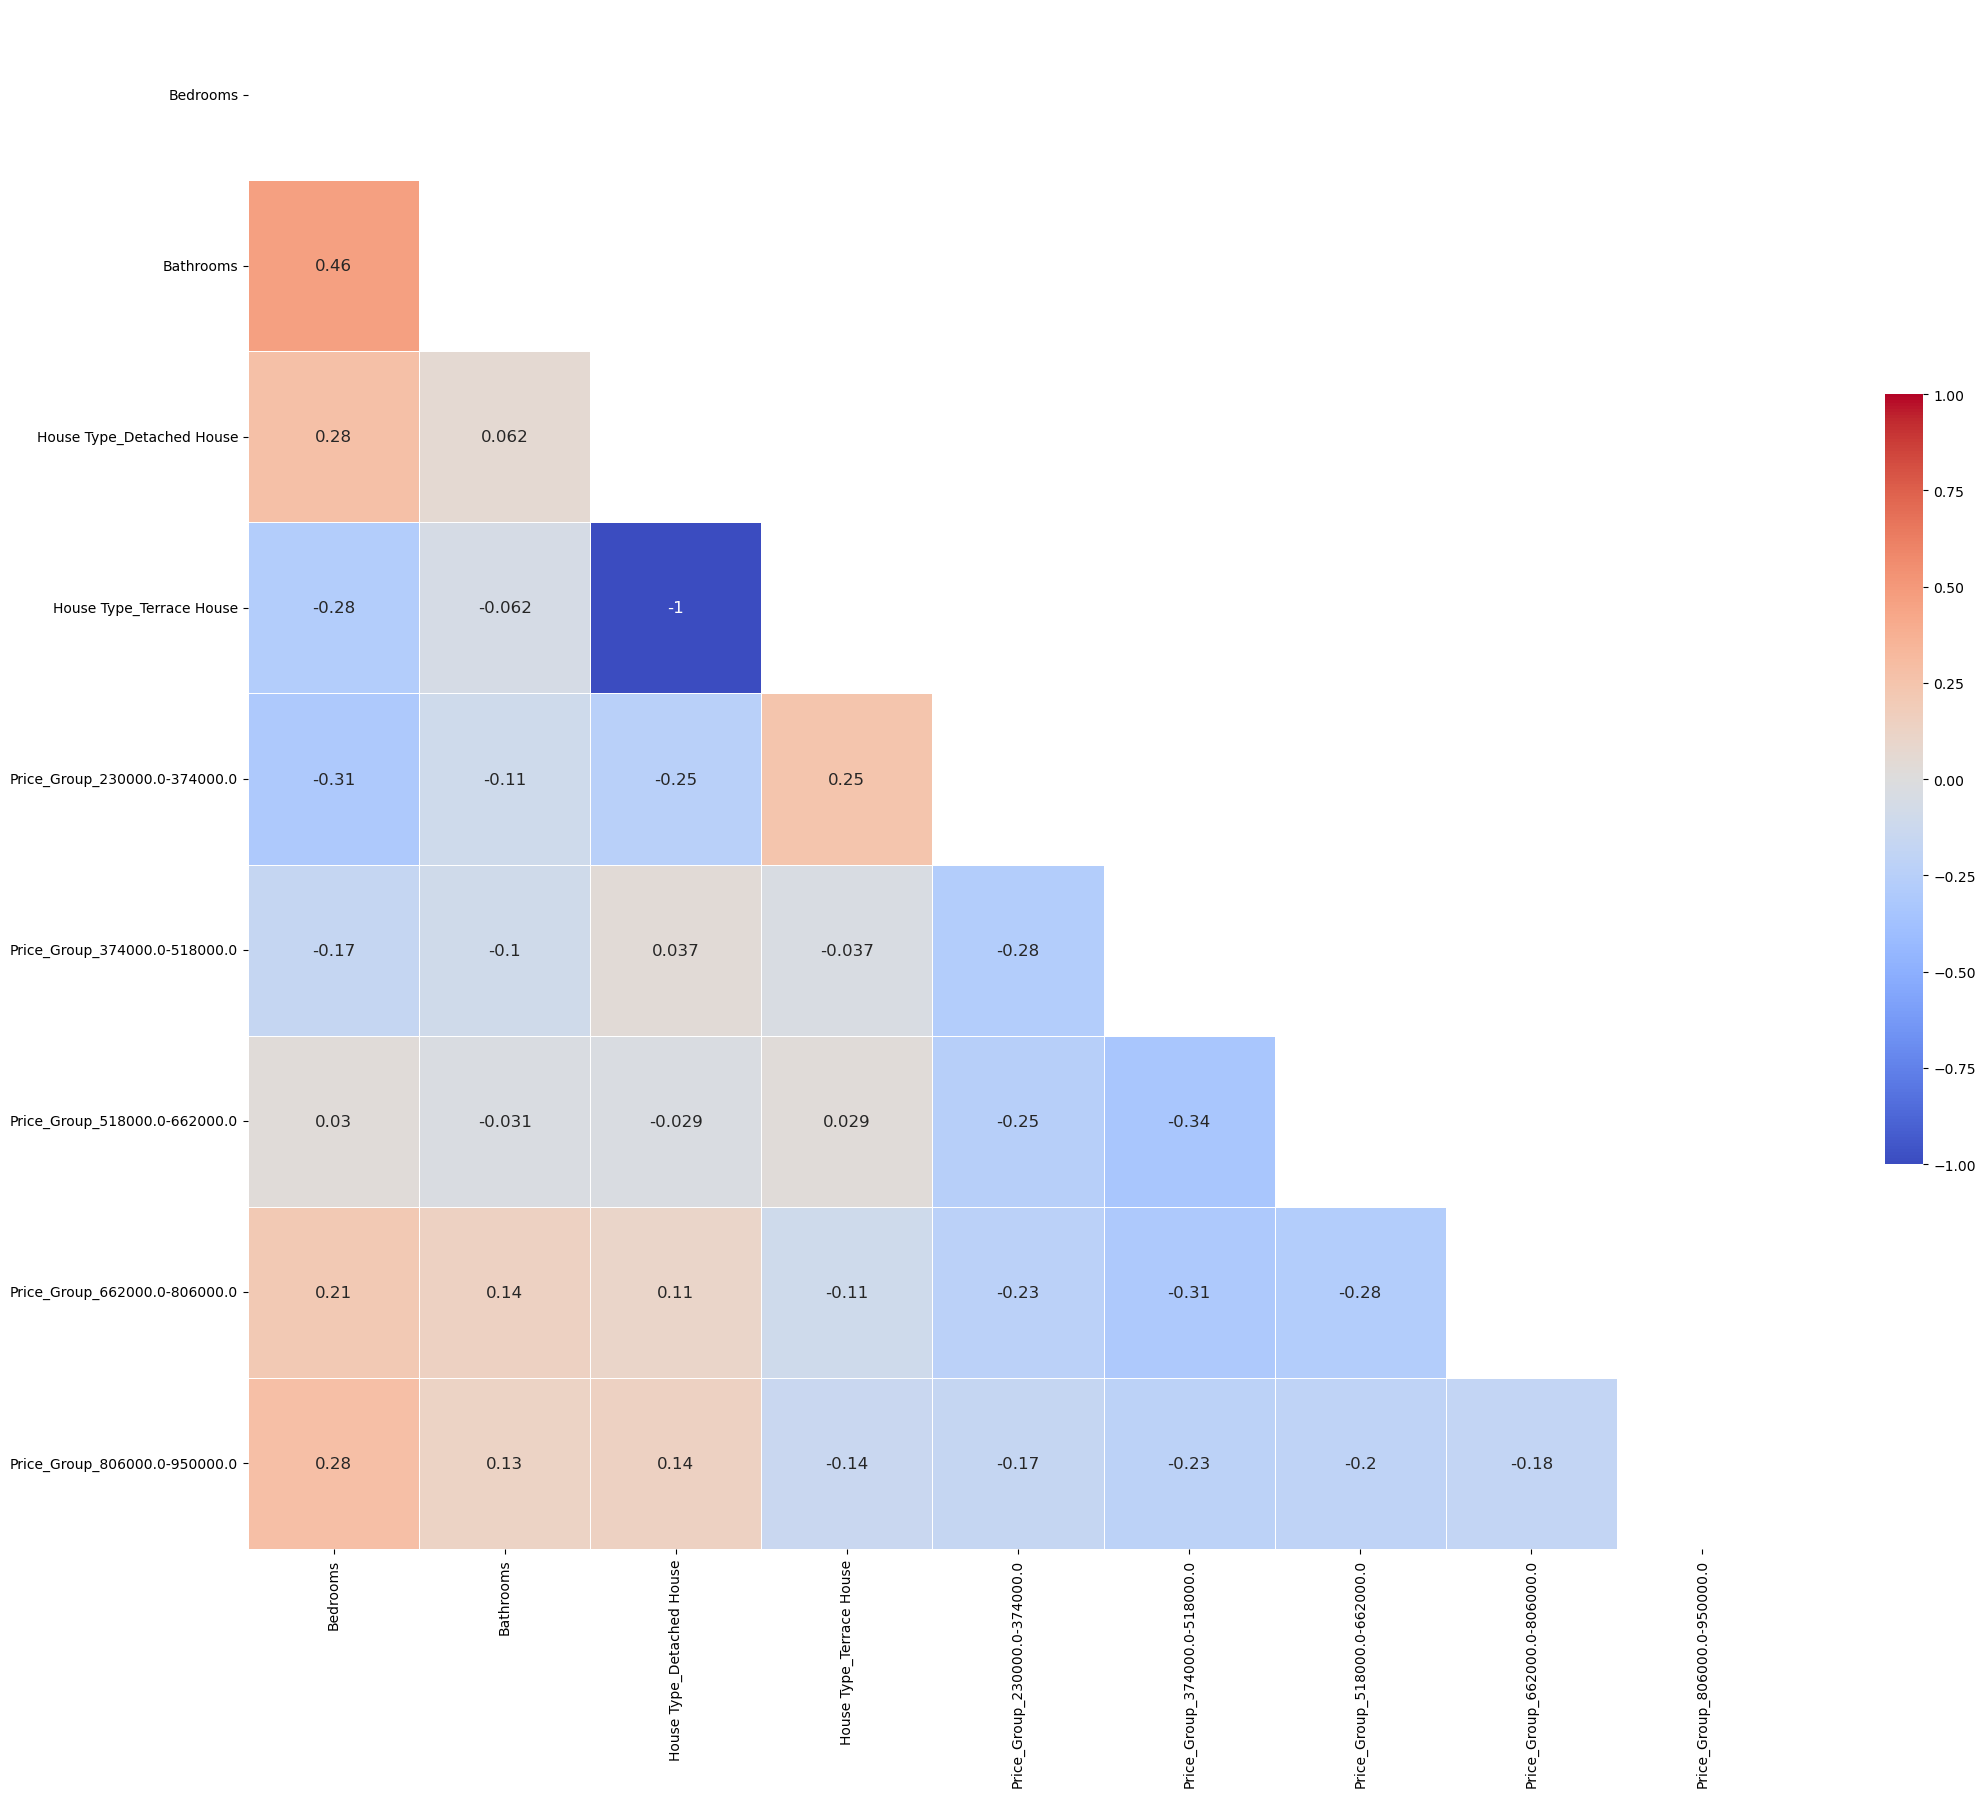

In [22]:
# checking correlation between variables
import numpy as np

# plotting heatmap
corrmat = df_Dublin.corr()

# setting mask for upper triangle
mask = np.triu(np.ones_like(corrmat, dtype=bool))

# setting hot-cold colour scheme
# cmap = sns.diverging_palette(240, 15, as_cmap=True)
cmap = 'coolwarm'

# plotting the graph
f, ax = plt.subplots(figsize=(25, 20))
sns.heatmap(corrmat, square = True, mask=mask, cmap=cmap,
            vmax=1, vmin=-1, center=0,
            annot = True, annot_kws = {'size': 12},
            linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

In [23]:
# importing libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [24]:
# separating features and target variable
X = df_Dublin.drop('District', axis=1)
y = df_Dublin['District']

In [25]:
# splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [26]:
df_Dublin.head()

,Bedrooms,Bathrooms,District,House Type_Detached House,House Type_Terrace House,Price_Group_230000.0-374000.0,Price_Group_374000.0-518000.0,Price_Group_518000.0-662000.0,Price_Group_662000.0-806000.0,Price_Group_806000.0-950000.0
0,3,2,Dublin,0,1,0,0,1,0,0
2,4,3,County,1,0,0,0,0,1,0
3,4,5,County,1,0,0,0,0,1,0
4,3,3,County,1,0,0,1,0,0,0
5,4,2,County,1,0,0,0,1,0,0


## 2.3. KNN
#### a) Standard code

In [27]:
from sklearn.neighbors import KNeighborsClassifier

# creating a KNN classifier with k=5
k = 5
knn = KNeighborsClassifier(n_neighbors=k)

# training the model on the training set
knn.fit(X_train, y_train)

# predicting the target variable for the test set
y_pred = knn.predict(X_test)

# calculating the model results
accuracy_KNN = accuracy_score(y_test, y_pred)
precision_KNN = precision_score(y_test, y_pred, pos_label='Dublin')
recall_KNN = recall_score(y_test, y_pred, pos_label='Dublin')
f1_KNN = f1_score(y_test, y_pred, pos_label='Dublin')

# calculating confusion matrix
confusion_mat_KNN = confusion_matrix(y_test, y_pred)

# printing the evaluation metrics and confusion matrix
print("Evaluation Metrics:")
print(f"Accuracy: {accuracy_KNN}")
print(f"Precision: {precision_KNN}")
print(f"Recall: {recall_KNN}")
print(f"F1 Score: {f1_KNN}")
print("Confusion Matrix:")
print(confusion_mat_KNN)

Evaluation Metrics:
Accuracy: 0.6511627906976745
Precision: 0.746031746031746
Recall: 0.7704918032786885
F1 Score: 0.7580645161290323
Confusion Matrix:
[[ 9 16]
 [14 47]]


In [28]:
# checking size of each class
from collections import Counter

# summarizing class distribution
print("Before oversampling: ",Counter(y_train))

Before oversampling:  Counter({'Dublin': 225, 'County': 119})


#### b) Addressing class imbalance - SMOTE

In [29]:
# oversampling using SMOTE
from imblearn.over_sampling import SMOTE

SMOTE = SMOTE()

In [30]:
# creating a KNN classifier with k=5
k = 5
knn = KNeighborsClassifier(n_neighbors=k)

# appling the transformation
X_train_SMOTE, y_train_SMOTE = SMOTE.fit_resample(X_train, y_train)

# training the model on the training set
knn.fit(X_train_SMOTE, y_train_SMOTE)

# predicting the target variable for the test set
y_pred = knn.predict(X_test)

# evaluating the model
accuracy_KNN2 = accuracy_score(y_test, y_pred)
precision_KNN2 = precision_score(y_test, y_pred, pos_label='Dublin')
recall_KNN2 = recall_score(y_test, y_pred, pos_label='Dublin')
f1_KNN2 = f1_score(y_test, y_pred, pos_label='Dublin')

# calculating the confusion matrix
confusion_mat_KNN2 = confusion_matrix(y_test, y_pred)

# printing the evaluation metrics and confusion matrix
print("Evaluation Metrics:")
print(f"Accuracy: {accuracy_KNN2}")
print(f"Precision: {precision_KNN2}")
print(f"Recall: {recall_KNN2}")
print(f"F1 Score: {f1_KNN2}")
print("Confusion Matrix:")
print(confusion_mat_KNN2)

Evaluation Metrics:
Accuracy: 0.627906976744186
Precision: 0.7457627118644068
Recall: 0.7213114754098361
F1 Score: 0.7333333333333334
Confusion Matrix:
[[10 15]
 [17 44]]


In [31]:
# summarizing class distribution
print("After oversampling: ",Counter(y_train_SMOTE))

After oversampling:  Counter({'County': 225, 'Dublin': 225})


#### c) Addressing class imbalance - BorderlineSMOTE

In [32]:
from imblearn.over_sampling import BorderlineSMOTE

# Aapling Borderline-SMOTE to oversample the minority class
Bsmote = BorderlineSMOTE()
X_train_Bsmote, y_train_Bsmote = Bsmote.fit_resample(X_train, y_train)

# creating a new KNN model with the optimal value of K
k = 5
knn = KNeighborsClassifier(n_neighbors=k)

# training the model on the oversampled training set
knn.fit(X_train_Bsmote, y_train_Bsmote)

# pedicting the target variable for the test set
y_pred = knn.predict(X_test)

# calculating the model results
accuracy_KNN3 = accuracy_score(y_test, y_pred)
precision_KNN3 = precision_score(y_test, y_pred, pos_label='Dublin')
recall_KNN3 = recall_score(y_test, y_pred, pos_label='Dublin')
f1_KNN3 = f1_score(y_test, y_pred, pos_label='Dublin')

# calculating the confusion matrix
confusion_mat_KNN3 = confusion_matrix(y_test, y_pred)

# printing the evaluation metrics and confusion matrix
print("Evaluation Metrics:")
print(f"Accuracy: {accuracy_KNN3}")
print(f"Precision: {precision_KNN3}")
print(f"Recall: {recall_KNN3}")
print(f"F1 Score: {f1_KNN3}")
print("Confusion Matrix:")
print(confusion_mat_KNN3)

Evaluation Metrics:
Accuracy: 0.6162790697674418
Precision: 0.7413793103448276
Recall: 0.7049180327868853
F1 Score: 0.7226890756302522
Confusion Matrix:
[[10 15]
 [18 43]]


#### d) Addressing class imbalance - SMOTE-ENN

In [33]:
from imblearn.combine import SMOTEENN

# appling SMOTE-ENN to oversample and undersample the data
smote_enn = SMOTEENN()
X_train_enn, y_train_enn = smote_enn.fit_resample(X_train, y_train)

# creating a new KNN model with the optimal value of K
k = 5
knn = KNeighborsClassifier(n_neighbors=k)

# training the model on the resampled training set
knn.fit(X_train_enn, y_train_enn)

# predicting the target variable for the test set
y_pred = knn.predict(X_test)

# calculating the model results
accuracy_KNN4 = accuracy_score(y_test, y_pred)
precision_KNN4 = precision_score(y_test, y_pred, pos_label='Dublin')
recall_KNN4 = recall_score(y_test, y_pred, pos_label='Dublin')
f1_KNN4 = f1_score(y_test, y_pred, pos_label='Dublin')

# calculating the confusion matrix
confusion_mat_KNN4 = confusion_matrix(y_test, y_pred)

# printing the evaluation metrics and confusion matrix
print("Evaluation Metrics:")
print(f"Accuracy: {accuracy_KNN4}")
print(f"Precision: {precision_KNN4}")
print(f"Recall: {recall_KNN4}")
print(f"F1 Score: {f1_KNN4}")
print("Confusion Matrix:")
print(confusion_mat_KNN4)

Evaluation Metrics:
Accuracy: 0.6162790697674418
Precision: 0.7258064516129032
Recall: 0.7377049180327869
F1 Score: 0.7317073170731708
Confusion Matrix:
[[ 8 17]
 [16 45]]


#### e) selecting best parameters

In [34]:
#defining the parameter grid
param_grid = {'n_neighbors': [2,3,4,5,6,7,8,9,10,11,12,13,14,15],
              'weights': ['uniform', 'distance']}

# creating a KNN classifier
knn = KNeighborsClassifier()

In [35]:
# performming grid search to find the best hyperparameters
grid_search = GridSearchCV(knn, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# getting the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:")
print(best_params)

# creating a new KNN classifier with the best hyperparameters
knn_best = KNeighborsClassifier(n_neighbors=best_params['n_neighbors'], weights=best_params['weights'])

# training the model on the training set
knn_best.fit(X_train, y_train)

# predicting the target variable for the test set
y_pred = knn_best.predict(X_test)

# calculating the model results
accuracy_KNN_hyp = accuracy_score(y_test, y_pred)
precision_KNN_hyp = precision_score(y_test, y_pred, pos_label='Dublin')
recall_KNN_hyp = recall_score(y_test, y_pred, pos_label='Dublin')
f1_KNN_hyp = f1_score(y_test, y_pred, pos_label='Dublin')

# Calculating confusion matrix
confusion_mat_KNN_hyp = confusion_matrix(y_test, y_pred)

# Print the evaluation metrics and confusion matrix
print(f"Accuracy: {accuracy_KNN_hyp}")
print(f"Precision: {precision_KNN_hyp}")
print(f"Recall: {recall_KNN_hyp}")
print(f"F1 Score: {f1_KNN_hyp}")
print("Confusion Matrix:")
print(confusion_mat_KNN_hyp)

Best Hyperparameters:
{'n_neighbors': 9, 'weights': 'uniform'}
Accuracy: 0.627906976744186
Precision: 0.7301587301587301
Recall: 0.7540983606557377
F1 Score: 0.7419354838709677
Confusion Matrix:
[[ 8 17]
 [15 46]]


In [36]:
# performming grid search to find the best hyperparameters
grid_search = GridSearchCV(knn, param_grid, cv=5)
grid_search.fit(X_train_SMOTE, y_train_SMOTE)

#getting the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:")
print(best_params)

# creating a new KNN classifier with the best hyperparameters
knn_best = KNeighborsClassifier(n_neighbors=best_params['n_neighbors'], weights=best_params['weights'])

#training the model on the training set
knn_best.fit(X_train_SMOTE, y_train_SMOTE)

# predicting the target variable for the test set
y_pred = knn_best.predict(X_test)

# calculating the model results
accuracy_KNN_hyp2 = accuracy_score(y_test, y_pred)
precision_KNN_hyp2 = precision_score(y_test, y_pred, pos_label='Dublin')
recall_KNN_hyp2 = recall_score(y_test, y_pred, pos_label='Dublin')
f1_KNN_hyp2 = f1_score(y_test, y_pred, pos_label='Dublin')

# calculating confusion matrix
confusion_mat_KNN_hyp2 = confusion_matrix(y_test, y_pred)

# printing the evaluation metrics and confusion matrix
print(f"Accuracy: {accuracy_KNN_hyp2}")
print(f"Precision: {precision_KNN_hyp2}")
print(f"Recall: {recall_KNN_hyp2}")
print(f"F1 Score: {f1_KNN_hyp2}")
print("Confusion Matrix:")
print(confusion_mat_KNN_hyp2)

Best Hyperparameters:
{'n_neighbors': 14, 'weights': 'uniform'}
Accuracy: 0.5465116279069767
Precision: 0.7037037037037037
Recall: 0.6229508196721312
F1 Score: 0.6608695652173914
Confusion Matrix:
[[ 9 16]
 [23 38]]


In [37]:
# performming the grid search to find the best hyperparameters
grid_search = GridSearchCV(knn, param_grid, cv=5)
grid_search.fit(X_train_Bsmote, y_train_Bsmote)

# getting the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:")
print(best_params)

# creating a new KNN classifier with the best hyperparameters
knn_best = KNeighborsClassifier(n_neighbors=best_params['n_neighbors'], weights=best_params['weights'])

# training the model on the training set
knn_best.fit(X_train_Bsmote, y_train_Bsmote)

# predicting the target variable for the test set
y_pred = knn_best.predict(X_test)

# calculating the model results
accuracy_KNN_hyp3 = accuracy_score(y_test, y_pred)
precision_KNN_hyp3 = precision_score(y_test, y_pred, pos_label='Dublin')
recall_KNN_hyp3 = recall_score(y_test, y_pred, pos_label='Dublin')
f1_KNN_hyp3 = f1_score(y_test, y_pred, pos_label='Dublin')

# calculate confusion matrix
confusion_mat_KNN_hyp3 = confusion_matrix(y_test, y_pred)

# printing the evaluation metrics and confusion matrix
print(f"Accuracy: {accuracy_KNN_hyp3}")
print(f"Precision: {precision_KNN_hyp3}")
print(f"Recall: {recall_KNN_hyp3}")
print(f"F1 Score: {f1_KNN_hyp3}")
print("Confusion Matrix:")
print(confusion_mat_KNN_hyp3)

Best Hyperparameters:
{'n_neighbors': 2, 'weights': 'distance'}
Accuracy: 0.5348837209302325
Precision: 0.7692307692307693
Recall: 0.4918032786885246
F1 Score: 0.6
Confusion Matrix:
[[16  9]
 [31 30]]


In [38]:
# performming grid search to find the best hyperparameters
grid_search = GridSearchCV(knn, param_grid, cv=5)
grid_search.fit(X_train_enn, y_train_enn)

# getting the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:")
print(best_params)

# creating a new KNN classifier with the best hyperparameters
knn_best = KNeighborsClassifier(n_neighbors=best_params['n_neighbors'], weights=best_params['weights'])

# training the model on the training set
knn_best.fit(X_train_enn, y_train_enn)

# predicting the target variable for the test set
y_pred = knn_best.predict(X_test)

# calculating the model results
accuracy_KNN_hyp4 = accuracy_score(y_test, y_pred)
precision_KNN_hyp4 = precision_score(y_test, y_pred, pos_label='Dublin')
recall_KNN_hyp4 = recall_score(y_test, y_pred, pos_label='Dublin')
f1_KNN_hyp4 = f1_score(y_test, y_pred, pos_label='Dublin')

# calculate confusion matrix
confusion_mat_KNN_hyp4 = confusion_matrix(y_test, y_pred)

# printing the evaluation metrics and confusion matrix
print(f"Accuracy: {accuracy_KNN_hyp4}")
print(f"Precision: {precision_KNN_hyp4}")
print(f"Recall: {recall_KNN_hyp4}")
print(f"F1 Score: {f1_KNN_hyp4}")
print("Confusion Matrix:")
print(confusion_mat_KNN_hyp4)

Best Hyperparameters:
{'n_neighbors': 2, 'weights': 'distance'}
Accuracy: 0.5697674418604651
Precision: 0.7307692307692307
Recall: 0.6229508196721312
F1 Score: 0.672566371681416
Confusion Matrix:
[[11 14]
 [23 38]]


### saving KNN results in a df

In [39]:
data = {
    'Type': ['Original', 'SMOTE', 'BorderlineSMOTE', 'SMOTEENN'],
    'Accuracy': [accuracy_KNN_hyp, accuracy_KNN_hyp2, accuracy_KNN_hyp3, accuracy_KNN_hyp4],
    'Precision': [precision_KNN_hyp, precision_KNN_hyp2, precision_KNN_hyp3, precision_KNN_hyp4],
    'Recall': [recall_KNN_hyp, recall_KNN_hyp2, recall_KNN_hyp3, recall_KNN_hyp4],
    'F1': [f1_KNN_hyp, f1_KNN_hyp2, f1_KNN_hyp3, f1_KNN_hyp4],
    'Confusion Matrix': [confusion_mat_KNN_hyp, confusion_mat_KNN_hyp2, confusion_mat_KNN_hyp3, confusion_mat_KNN_hyp4]
}

# Create the DataFrame
df_KNN_results = pd.DataFrame(data)
df_KNN_results

,Type,Accuracy,Precision,Recall,F1,Confusion Matrix
0,Original,0.627907,0.730159,0.754098,0.741935,"[[8, 17], [15, 46]]"
1,SMOTE,0.546512,0.703704,0.622951,0.660870,"[[9, 16], [23, 38]]"
2,BorderlineSMOTE,0.534884,0.769231,0.491803,0.600000,"[[16, 9], [31, 30]]"
3,SMOTEENN,0.569767,0.730769,0.622951,0.672566,"[[11, 14], [23, 38]]"


# Random Forest
### a) Standard code

In [40]:
from sklearn.ensemble import RandomForestClassifier

# creating a random forest classifier
rf_classifier = RandomForestClassifier()

# trainning the model
rf_classifier.fit(X_train, y_train)

# making the predictions on the test data
y_pred = rf_classifier.predict(X_test)

# calculating the model results
accuracy_rf = accuracy_score(y_test, y_pred)
precision_rf = precision_score(y_test, y_pred,pos_label='Dublin')
recall_rf = recall_score(y_test, y_pred,pos_label='Dublin')
f1_rf = f1_score(y_test, y_pred,pos_label='Dublin')

# calculating confusion matrix
confusion_mat_rf = confusion_matrix(y_test, y_pred)

# printing the evaluation metrics and confusion matrix
print(f"Accuracy: {accuracy_rf}")
print(f"Precision: {precision_rf}")
print(f"Recall: {recall_rf}")
print(f"F1 Score: {f1_rf}")
print("Confusion Matrix:")
print(confusion_mat_rf)

Accuracy: 0.6511627906976745
Precision: 0.746031746031746
Recall: 0.7704918032786885
F1 Score: 0.7580645161290323
Confusion Matrix:
[[ 9 16]
 [14 47]]


#### b) Hyperparameters search

In [41]:
# defining the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest
    'max_depth': [None, 5, 10],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4]  # Minimum number of samples required to be at a leaf node
}

# creating a random forest classifier
rf_classifier = RandomForestClassifier()

# creating GridSearchCV object
grid_search = GridSearchCV(rf_classifier, param_grid, cv=5, scoring='accuracy')

# fitting the model on the SMOTE training set
grid_search.fit(X_train, y_train)

# getting the best hyperparameters and the best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# making predictions on the test data using the best model
y_pred = best_model.predict(X_test)

# calculating the model results
accuracy_rf1 = accuracy_score(y_test, y_pred)
precision_rf1 = precision_score(y_test, y_pred, pos_label='Dublin')
recall_rf1 = recall_score(y_test, y_pred, pos_label='Dublin')
f1_rf1 = f1_score(y_test, y_pred, pos_label='Dublin')

# calculating confusion matrix
confusion_mat_rf1 = confusion_matrix(y_test, y_pred)

# printing the evaluation metrics, best hyperparameters, and confusion matrix
print(f"Accuracy: {accuracy_rf1}")
print(f"Precision: {precision_rf1}")
print(f"Recall: {recall_rf1}")
print(f"F1 Score: {f1_rf1}")

print("Confusion Matrix:")
print(confusion_mat_rf1)

print("Best Hyperparameters:")
print(best_params)

Accuracy: 0.6976744186046512
Precision: 0.7464788732394366
Recall: 0.8688524590163934
F1 Score: 0.803030303030303
Confusion Matrix:
[[ 7 18]
 [ 8 53]]
Best Hyperparameters:
{'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300}


#### c) Boosting

In [82]:
# Ada Boosting

import time
import memory_profiler
from sklearn.ensemble import AdaBoostClassifier

# creating the base estimator with the best hyperparameters
base_estimator = RandomForestClassifier(max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=300)

# creating the AdaBoost classifier with the base estimator
boosted_classifier = AdaBoostClassifier(base_estimator=base_estimator)

# starting measuring time
start_time = time.time()

# getting initial memory usage
initial_memory = memory_profiler.memory_usage()[0]

# fitting the model on the training set
boosted_classifier.fit(X_train, y_train)

# getting the final memory usage
final_memory = memory_profiler.memory_usage()[0]

# calculating memory usage during fitting
mem_usage_ADA = final_memory - initial_memory

# calculating the elapsed time
elapsed_time_ADA = time.time() - start_time

# making predictions on the test data
y_pred = boosted_classifier.predict(X_test)

# calculating the model results
accuracy_ADA = accuracy_score(y_test, y_pred)
precision_ADA = precision_score(y_test, y_pred, pos_label='Dublin')
recall_ADA = recall_score(y_test, y_pred, pos_label='Dublin')
f1_ADA = f1_score(y_test, y_pred, pos_label='Dublin')

# calculating confusion matrix
confusion_mat_ADA = confusion_matrix(y_test, y_pred)

# printing the evaluation metrics and confusion matrix
print(f"Accuracy: {accuracy_ADA}")
print(f"Precision: {precision_ADA}")
print(f"Recall: {recall_ADA}")
print(f"F1 Score: {f1_ADA}")
print("Confusion Matrix:")
print(confusion_mat_ADA)

# printing the elapsed time
print("Elapsed Time:", elapsed_time_ADA, "seconds")

# Print the memory usage
print("Memory Usage:", mem_usage_ADA, "MB")

Accuracy: 0.6627906976744186
Precision: 0.75
Recall: 0.7868852459016393
F1 Score: 0.768
Confusion Matrix:
[[ 9 16]
 [13 48]]
Elapsed Time: 14.682973146438599 seconds
Memory Usage: 24.92578125 MB


In [96]:
# LIGHT Gredient Boosting Machine

from lightgbm import LGBMClassifier


# creating the LightGBM classifier with the base estimator
LGBM_classifier = LGBMClassifier(boosting_type='gbdt', n_estimators=100, learning_rate=0.1)

# starting measuring time
start_time = time.time()

# getting the initial memory usage
initial_memory = memory_profiler.memory_usage()[0]

# fitting the model on the training set
LGBM_classifier.fit(X_train, y_train)

# getting final memory usage
final_memory = memory_profiler.memory_usage()[0]

# calculating memory usage during fitting
mem_usage_LG = final_memory - initial_memory

# calculating the elapsed time
elapsed_time_LG = time.time() - start_time

# making predictions on the test data
y_pred = LGBM_classifier.predict(X_test)

# calculating the model results
accuracy_LG = accuracy_score(y_test, y_pred)
precision_LG = precision_score(y_test, y_pred, pos_label='Dublin')
recall_LG = recall_score(y_test, y_pred, pos_label='Dublin')
f1_LG = f1_score(y_test, y_pred, pos_label='Dublin')

# calculating confusion matrix
confusion_mat_LG = confusion_matrix(y_test, y_pred)

# printing the evaluation metrics and confusion matrix
print(f"Accuracy: {accuracy_LG}")
print(f"Precision: {precision_LG}")
print(f"Recall: {recall_LG}")
print(f"F1 Score: {f1_LG}")
print("Confusion Matrix:")
print(confusion_mat_LG)

# printing the elapsed time
print("Elapsed Time:", elapsed_time_LG, "seconds")

# printing the memory usage
print("Memory Usage:", mem_usage_LG, "MB")

Accuracy: 0.6395348837209303
Precision: 0.7272727272727273
Recall: 0.7868852459016393
F1 Score: 0.7559055118110236
Confusion Matrix:
[[ 7 18]
 [13 48]]
Elapsed Time: 0.25388050079345703 seconds
Memory Usage: 0.078125 MB


In [97]:
# Gradient Boosting

from sklearn.ensemble import GradientBoostingClassifier
import psutil


# creatiting the Gradient Boosting classifier
GB_classifier = GradientBoostingClassifier()

# starting measuring the time
start_time = time.time()

# fittinf the model on the training set
GB_classifier.fit(X_train, y_train)

# calculating the elapsed time
elapsed_time_GB = time.time() - start_time

# making predictions on the test data
y_pred = GB_classifier.predict(X_test)

# calculating the evaluation metrics
accuracy_GB = accuracy_score(y_test, y_pred)
precision_GB = precision_score(y_test, y_pred, pos_label='Dublin')
recall_GB = recall_score(y_test, y_pred, pos_label='Dublin')
f1_GB = f1_score(y_test, y_pred, pos_label='Dublin')

# calculating the confusion matrix
confusion_mat_GB = confusion_matrix(y_test, y_pred)

# printing the evaluation metrics and confusion matrix
print(f"Accuracy: {accuracy_GB}")
print(f"Precision: {precision_GB}")
print(f"Recall: {recall_GB}")
print(f"F1 Score: {f1_GB}")
print("Confusion Matrix:")
print(confusion_mat_GB)

# measuring memory usage
process = psutil.Process()
mem_usage_GB = process.memory_info().rss

# printing memory usage and elapsed time
print(f"Memory Usage: {mem_usage_GB / 1024 / 1024} MB")
print(f"Elapsed Time: {elapsed_time_GB} seconds")

Accuracy: 0.7093023255813954
Precision: 0.7571428571428571
Recall: 0.8688524590163934
F1 Score: 0.8091603053435115
Confusion Matrix:
[[ 8 17]
 [ 8 53]]
Memory Usage: 310.546875 MB
Elapsed Time: 0.0498347282409668 seconds


In [98]:
# SAving the boosting results

data_B= {
    'Type': ['Ada Boosting', 'LIGHT Gradient Boosting', 'Gradiendt Boosting'],
    'Time (s)': [elapsed_time_ADA, elapsed_time_LG, elapsed_time_GB],
    'Memory MB': [mem_usage_ADA ,mem_usage_LG, mem_usage_GB],
    'F1': [f1_ADA, f1_LG, f1_GB]
}

# creating the DataFrame
df_RF_Bresults = pd.DataFrame(data_B)
df_RF_Bresults

,Type,Time (s),Memory MB,F1
0,Ada Boosting,14.682973,2.492578e+01,0.768000
1,LIGHT Gradient Boosting,0.253881,7.812500e-02,0.755906
2,Gradiendt Boosting,0.049835,3.256320e+08,0.809160


#### d) Bagging

In [118]:
from sklearn.ensemble import BaggingClassifier
import time
# creating the base estimator with the best hyperparameters
base_estimator = RandomForestClassifier(max_depth= 5, min_samples_leaf= 2, min_samples_split= 5, n_estimators= 300)

# creating the Bagging classifier with the base estimator
bagging_classifier = BaggingClassifier(base_estimator=base_estimator)

# starting the timer
start_time = time.time()

# fitting the model on the training set
bagging_classifier.fit(X_train, y_train)

# measuring the memory usage after fitting the model
mem_usage_end = memory_profiler.memory_usage()[0]
mem_usage_bagging = mem_usage_end - mem_usage_start

# calculating the elapsed time
elapsed_time_bagging = time.time() - start_time

# making predictions on the test data
y_pred = bagging_classifier.predict(X_test)

# calculating the model results
accuracy_bagging = accuracy_score(y_test, y_pred)
precision_bagging = precision_score(y_test, y_pred, pos_label='Dublin')
recall_bagging = recall_score(y_test, y_pred, pos_label='Dublin')
f1_bagging = f1_score(y_test, y_pred, pos_label='Dublin')

# Calculate confusion matrix
confusion_mat_bagging = confusion_matrix(y_test, y_pred)

# printing the evaluation metrics and confusion matrix
print(f"Accuracy: {accuracy_bagging}")
print(f"Precision: {precision_bagging}")
print(f"Recall: {recall_bagging}")
print(f"F1 Score: {f1_bagging}")
print("Confusion Matrix:")
print(confusion_mat_bagging)

# printing memory usage and elapsed time
print(f"Memory Usage: {mem_usage_bagging} MB")
print(f"Elapsed Time: {elapsed_time_bagging} seconds")

Accuracy: 0.686046511627907
Precision: 0.75
Recall: 0.8360655737704918
F1 Score: 0.7906976744186046
Confusion Matrix:
[[ 8 17]
 [10 51]]
Memory Usage: 2.390625 MB
Elapsed Time: 2.7058186531066895 seconds


In [119]:
from sklearn.ensemble import ExtraTreesClassifier

# Measure memory usage before fitting the model
mem_usage_start = memory_profiler.memory_usage()[0]

# Create the ExtraTreesClassifier
extra_trees_classifier = ExtraTreesClassifier(n_estimators=300, max_depth=5, min_samples_leaf=2, min_samples_split=5)

# starting the timer
start_time = time.time()

# Fit the model on the training set
extra_trees_classifier.fit(X_train, y_train)

# measuring the memory usage after fitting the model
mem_usage_end = memory_profiler.memory_usage()[0]
mem_usage_trees = mem_usage_end - mem_usage_start

# calculating the elapsed time
elapsed_time_trees = time.time() - start_time

# Making predictions on the test data
y_pred = extra_trees_classifier.predict(X_test)

# Calculating the model results
accuracy_extra_trees = accuracy_score(y_test, y_pred)
precision_extra_trees = precision_score(y_test, y_pred, pos_label='Dublin')
recall_extra_trees = recall_score(y_test, y_pred, pos_label='Dublin')
f1_extra_trees = f1_score(y_test, y_pred, pos_label='Dublin')

# Calculate the confusion matrix
confusion_mat_extra_trees = confusion_matrix(y_test, y_pred)

# Print the evaluation metrics and confusion matrix
print(f"Accuracy: {accuracy_extra_trees}")
print(f"Precision: {precision_extra_trees}")
print(f"Recall: {recall_extra_trees}")
print(f"F1 Score: {f1_extra_trees}")
print("Confusion Matrix:")
print(confusion_mat_extra_trees)

# printing memory usage and elapsed time
print(f"Memory Usage: {mem_usage_trees} MB")
print(f"Elapsed Time: {elapsed_time_trees} seconds")

Accuracy: 0.6976744186046512
Precision: 0.7464788732394366
Recall: 0.8688524590163934
F1 Score: 0.803030303030303
Confusion Matrix:
[[ 7 18]
 [ 8 53]]
Memory Usage: 0.13671875 MB
Elapsed Time: 0.3254377841949463 seconds


In [120]:
# Histogram-Based Gradient Boosting Classifier

from sklearn.ensemble import HistGradientBoostingClassifier

# creating the HistGradientBoostingClassifier
histboost_classifier = HistGradientBoostingClassifier()

# starting the timer
start_time = time.time()

# measuring the memory usage before fitting the model
mem_usage_start = memory_profiler.memory_usage()[0]

# fitting the model on the training set
histboost_classifier.fit(X_train, y_train)

# measuring the memory usage after fitting the model
mem_usage_end = memory_profiler.memory_usage()[0]
mem_usage_hist = mem_usage_end - mem_usage_start

# calculating the elapsed time
elapsed_time_hist = time.time() - start_time

# making predictions on the test data
y_pred = histboost_classifier.predict(X_test)

# calculating the model results
accuracy_histboost = accuracy_score(y_test, y_pred)
precision_histboost = precision_score(y_test, y_pred, pos_label='Dublin')
recall_histboost = recall_score(y_test, y_pred, pos_label='Dublin')
f1_histboost = f1_score(y_test, y_pred, pos_label='Dublin')

# calculating the confusion matrix
confusion_mat_histboost = confusion_matrix(y_test, y_pred)

# printing the evaluation metrics and confusion matrix
print(f"Accuracy: {accuracy_histboost}")
print(f"Precision: {precision_histboost}")
print(f"Recall: {recall_histboost}")
print(f"F1 Score: {f1_histboost}")
print("Confusion Matrix:")
print(confusion_mat_histboost)

# printing memory usage and elapsed time
print(f"Memory Usage: {mem_usage_hist} MB")
print(f"Elapsed Time: {elapsed_time_hist} seconds")

Accuracy: 0.6511627906976745
Precision: 0.7313432835820896
Recall: 0.8032786885245902
F1 Score: 0.765625
Confusion Matrix:
[[ 7 18]
 [12 49]]
Memory Usage: 0.09765625 MB
Elapsed Time: 0.41576409339904785 seconds


In [122]:
# Saving the boosting results

data_Bag= {
    'Type': ['Bagging Classifier', 'Extra Trees Classifier', 'Histogram-Based Gradient Boosting Classifier'],
    'Time (s)': [elapsed_time_bagging, elapsed_time_trees, elapsed_time_hist],
    'Memory MB': [mem_usage_bagging ,mem_usage_trees, mem_usage_hist],
    'F1': [f1_bagging, f1_extra_trees, f1_histboost]
}

# creating the DataFrame
df_RF_Bag = pd.DataFrame(data_Bag)
df_RF_Bag

,Type,Time (s),Memory MB,F1
0,Bagging Classifier,2.705819,2.390625,0.790698
1,Extra Trees Classifier,0.325438,0.136719,0.803030
2,Histogram-Based Gradient Boosting Classifier,0.415764,0.097656,0.765625


#### e) Saving the results

In [104]:
data1 = {
    'Type': ['Original', 'ParamGrid', 'Gradient Boosting', 'Bagging'],
    'Accuracy': [accuracy_rf, accuracy_rf1, accuracy_GB, accuracy_bagging],
    'Precision': [precision_rf, precision_rf1, precision_GB, precision_bagging],
    'Recall': [recall_rf, recall_rf1, recall_GB, recall_bagging],
    'F1': [f1_rf, f1_rf1, f1_GB, f1_bagging],
    'Confusion Matrix': [confusion_mat_rf, confusion_mat_rf1, confusion_mat_GB, confusion_mat_bagging]
}

# creating the DataFrame
df_RF_results = pd.DataFrame(data1)
df_RF_results

,Type,Accuracy,Precision,Recall,F1,Confusion Matrix
0,Original,0.651163,0.746032,0.770492,0.758065,"[[9, 16], [14, 47]]"
1,ParamGrid,0.697674,0.746479,0.868852,0.803030,"[[7, 18], [8, 53]]"
2,Gradient Boosting,0.709302,0.757143,0.868852,0.809160,"[[8, 17], [8, 53]]"
3,Bagging,0.709302,0.736842,0.918033,0.817518,"[[5, 20], [5, 56]]"


# Unsupervised ml

In [59]:
df_Dublin.head()

,Bedrooms,Bathrooms,District,House Type_Detached House,House Type_Terrace House,Price_Group_230000.0-374000.0,Price_Group_374000.0-518000.0,Price_Group_518000.0-662000.0,Price_Group_662000.0-806000.0,Price_Group_806000.0-950000.0
0,3,2,Dublin,0,1,0,0,1,0,0
2,4,3,County,1,0,0,0,0,1,0
3,4,5,County,1,0,0,0,0,1,0
4,3,3,County,1,0,0,1,0,0,0
5,4,2,County,1,0,0,0,1,0,0


In [60]:
# getting dummies for 'House Type' column
df_Dublin = pd.get_dummies(df_Dublin, columns=['District'])

df_Dublin.head()

,Bedrooms,Bathrooms,House Type_Detached House,House Type_Terrace House,Price_Group_230000.0-374000.0,Price_Group_374000.0-518000.0,Price_Group_518000.0-662000.0,Price_Group_662000.0-806000.0,Price_Group_806000.0-950000.0,District_County,District_Dublin
0,3,2,0,1,0,0,1,0,0,0,1
2,4,3,1,0,0,0,0,1,0,1,0
3,4,5,1,0,0,0,0,1,0,1,0
4,3,3,1,0,0,1,0,0,0,1,0
5,4,2,1,0,0,0,1,0,0,1,0


In [61]:
# checking how many missing values is in columns
df_Dublin.isna().sum() 

Bedrooms                         0
Bathrooms                        0
House Type_Detached House        0
House Type_Terrace House         0
Price_Group_230000.0-374000.0    0
Price_Group_374000.0-518000.0    0
Price_Group_518000.0-662000.0    0
Price_Group_662000.0-806000.0    0
Price_Group_806000.0-950000.0    0
District_County                  0
District_Dublin                  0
dtype: int64

In [63]:
from sklearn.ensemble import IsolationForest

# Create an Isolation Forest model
model = IsolationForest()

# Fit the model to the data
model.fit(df_Dublin)

# Predict anomaly scores for each data point
anomaly_scores = model.decision_function(df_Dublin)

In [64]:
# Add the anomaly scores as a new column in df_Dublin
df_Dublin['Anomaly Score'] = anomaly_scores
df_Dublin.head()

,Bedrooms,Bathrooms,House Type_Detached House,House Type_Terrace House,Price_Group_230000.0-374000.0,Price_Group_374000.0-518000.0,Price_Group_518000.0-662000.0,Price_Group_662000.0-806000.0,Price_Group_806000.0-950000.0,District_County,District_Dublin,Anomaly Score
0,3,2,0,1,0,0,1,0,0,0,1,0.023585
2,4,3,1,0,0,0,0,1,0,1,0,0.010911
3,4,5,1,0,0,0,0,1,0,1,0,-0.100937
4,3,3,1,0,0,1,0,0,0,1,0,0.032270
5,4,2,1,0,0,0,1,0,0,1,0,-0.040784


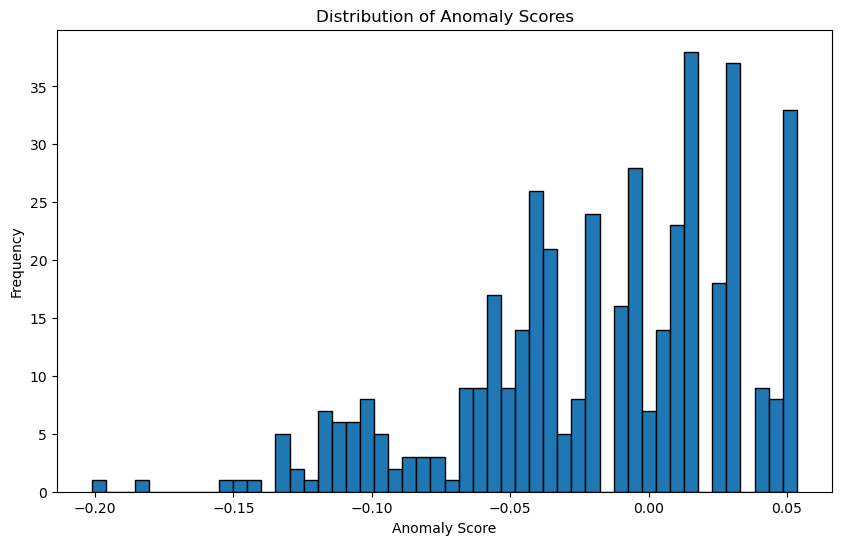

In [65]:

plt.figure(figsize=(10, 6))
plt.hist(df_Dublin['Anomaly Score'], bins=50, edgecolor='black')
plt.xlabel('Anomaly Score')
plt.ylabel('Frequency')
plt.title('Distribution of Anomaly Scores')
plt.show()

In [66]:
anomaly_threshold = -0.15
anomaly_rows = df_Dublin[df_Dublin['Anomaly Score'] < anomaly_threshold]
anomaly_rows

,Bedrooms,Bathrooms,House Type_Detached House,House Type_Terrace House,Price_Group_230000.0-374000.0,Price_Group_374000.0-518000.0,Price_Group_518000.0-662000.0,Price_Group_662000.0-806000.0,Price_Group_806000.0-950000.0,District_County,District_Dublin,Anomaly Score
433,8,6,0,1,0,0,0,1,0,0,1,-0.201017
835,5,5,1,0,0,0,1,0,0,1,0,-0.151684
852,6,6,0,1,0,0,1,0,0,0,1,-0.181513


# SENTIMENT ANALYSIS

In [150]:
# # getting User-Agent from https://httpbin.org/get
# headers = { "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/105.0.0.0 Safari/537.36 Edg/105.0.1343.27", "Accept-Encoding":"gzip, deflate", "Accept":"text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8", "DNT":"1","Connection":"close", "Upgrade-Insecure-Requests":"1"}


# today = date.today() 

In [151]:
# # assigning the baseurl and putting search thourch few pages

# baseurl2 = 'https://ie.trustpilot.com'

# productlinks = []
# for x in range(1,4):
#     r = requests.get(f'https://ie.trustpilot.com/review/www.murphylarkin.com?page={x}')
#     soup = BeautifulSoup(r.content, 'html.parser')
#     productlist = soup.find_all('div', class_='styles_cardWrapper__LcCPA styles_show__HUXRb styles_reviewCard__9HxJJ')

#     for item in productlist:
#         link = item.find('a', href=True)
#         if link:
#             productlinks.append(baseurl2 + link['href'])

In [152]:
# Reviews = []
# for link in productlinks:
#     r = requests.get(link, headers=headers)
#     soup = BeautifulSoup(r.content, 'lxml')
    
#     # finding line where is the 'name' of product, removing unwanted characters behind name
#     na = soup.find("span", class_="typography_heading-xxs__QKBS8 typography_appearance-default__AAY17")
#     # Extract the name
#     name = na.get_text(strip=True)
    
    
#     no = soup.find("span", class_="typography_body-m__xgxZ_ typography_appearance-subtle__8_H2l")
#     Number = no.get_text(strip=True)
#     Number2 = Number.replace("reviews", "").replace("review", "")

#     if soup.find(text='Verified'):
#         verified = 'Yes'
#     else:
#         verified = 'No'
        
#     t = soup.find('h2', class_='typography_heading-s__f7029 typography_appearance-default__AAY17')
#     title = t.get_text(strip=True)
    
#     re = soup.find('p', class_ = 'typography_body-l__KUYFJ typography_appearance-default__AAY17 typography_color-black__5LYEn')
#     Review = re.get_text(strip=True)
 
#     # extracting the 'time' element
#     time_element = soup.find('time')

#     # extracting the 'datetime' attribute value
#     datetime_str = time_element['datetime']

#     # defining the format string for parsing the datetime
#     format_str = "%Y-%m-%dT%H:%M:%S.%fZ"

#     # converting the datetime string to a datetime object
#     datetime_obj = datetime.strptime(datetime_str, format_str)

#     # extracting the date and time components
#     date = datetime_obj.date()
#     time = datetime_obj.time()


#     # creating a dictionary to save data
#     rev = {
#         'Date': date,
#         'Time': time,
#         'Name' :name,
#         'Verified':verified,
#         'No of Reviews':Number2,
#         'Title': title,
#         'Review':Review}
#     Reviews.append(rev)
#     print(rev)

{'Date': datetime.date(2023, 5, 12), 'Time': datetime.time(21, 21, 14), 'Name': 'AUDREY QUINN', 'Verified': 'Yes', 'No of Reviews': '3', 'Title': 'DEANTA DOORS Black Glass . We ordered our doors on the Tuesday not…', 'Review': 'We ordered our doors on the Tuesday not anticipating them to arrive for at least 12 days and Amazingly they arrived on the Thursday 2 days later.with clear instructions on how to acclimatise to their environment.We are very happy with the service and we will he returning to the website again.'}
{'Date': datetime.date(2023, 5, 10), 'Time': datetime.time(20, 59, 35), 'Name': 'Stephen', 'Verified': 'Yes', 'No of Reviews': '6', 'Title': 'Excellent service!', 'Review': 'Excellent service!Ordered delivered within 2 days - received calls throughout and after - best service.Bought from other provider recently and service was not anything like service from Murphy Larkin!'}
{'Date': datetime.date(2023, 5, 8), 'Time': datetime.time(8, 20, 21), 'Name': 'Emmet Gaule', 'Verif

In [153]:
# # # transforming dictionary into DF
# df = pd.DataFrame(Reviews)
# df.head(10)

,Date,Time,Name,Verified,No of Reviews,Title,Review
0,2023-05-12,21:21:14,AUDREY QUINN,Yes,3,DEANTA DOORS Black Glass . We ordered our door...,We ordered our doors on the Tuesday not antici...
1,2023-05-10,20:59:35,Stephen,Yes,6,Excellent service!,Excellent service!Ordered delivered within 2 d...
2,2023-05-08,08:20:21,Emmet Gaule,Yes,2,Great service in the Tramore branch.,Order placed online. Follow up call with me to...
3,2023-05-09,18:34:28,Gavin Tuite,Yes,3,Good service and delivery however quite…,Good service and delivery however quite a few ...
4,2023-05-10,22:36:53,Richard Sayers,Yes,1,Great service ordered online and got a…,Great service ordered online and got a call ne...
5,2023-05-10,08:50:40,Aquilla Moyo,Yes,3,The timber is good quality and the…,The timber is good quality and the measurement...
6,2023-05-08,20:19:29,Stephen O'Neill,Yes,1,Very prompt delivery,Very prompt delivery. Even followed up to make...
7,2023-04-26,10:31:44,Gerry,Yes,9,Product arrived quickly and I even…,Product arrived quickly and I even received a ...
8,2023-05-01,23:20:10,Lucy,Yes,10,great experience shopping…,As always a great experience shopping with The...
9,2023-04-20,20:08:36,AZ,Yes,2,"Second purchase, again amazing!",Second purchase. Same as the last time- everyt...


In [154]:
# saving file into and excel file
#df.to_excel('C:\\ESTERA\\CA2\\data sets - IRL\\Sentiment.xlsx', index=False)

In [281]:
# loading the Sentiment file
df = pd.read_excel('C:\\ESTERA\\CA2\\data sets - IRL\\Sentiment.xlsx')
df.head()

,Date,Time,Name,Verified,No of Reviews,Title,Review
0,2023-05-12,21:21:14,AUDREY QUINN,Yes,3,DEANTA DOORS Black Glass . We ordered our door...,We ordered our doors on the Tuesday not antici...
1,2023-05-10,20:59:35,Stephen,Yes,6,Excellent service!,Excellent service!Ordered delivered within 2 d...
2,2023-05-08,08:20:21,Emmet Gaule,Yes,2,Great service in the Tramore branch.,Order placed online. Follow up call with me to...
3,2023-05-09,18:34:28,Gavin Tuite,Yes,3,Good service and delivery however quite…,Good service and delivery however quite a few ...
4,2023-05-10,22:36:53,Richard Sayers,Yes,1,Great service ordered online and got a…,Great service ordered online and got a call ne...


In [282]:
# keeping only the first name
df['First Name'] = df['Name'].str.split().str[0]

# dropping the original 'Name' column
df.drop('Name', axis=1, inplace=True)

In [283]:
# creating the function to get gender from a name
def get_gender(name):
    try:
        genders = Genderize().get([name])
        if genders:
            gender = genders[0]['gender']
            probability = genders[0]['probability']
            if probability >= 0.9:
                return gender
    except:
        pass
    return 'Unknown'

# appling the gender detection function to each name in the DataFrame column
df['Gender'] = df['First Name'].apply(get_gender)


In [304]:
# checking columns type
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           60 non-null     datetime64[ns]
 1   Time           60 non-null     datetime64[ns]
 2   Verified       60 non-null     object        
 3   No of Reviews  60 non-null     int64         
 4   Title          60 non-null     object        
 5   Review         60 non-null     object        
 6   First Name     60 non-null     object        
 7   Gender         60 non-null     object        
 8   Review_mod     60 non-null     object        
 9   sentiment      60 non-null     float64       
 10  Week Start     60 non-null     datetime64[ns]
 11  Week End       60 non-null     datetime64[ns]
 12  Hour           60 non-null     int64         
dtypes: datetime64[ns](4), float64(1), int64(2), object(6)
memory usage: 6.2+ KB


In [285]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ester\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [286]:
# putting all in lower case
df['Review_mod'] = df['Review'].apply(lambda x: ' '.join(x.lower() for x in x.split()))

In [287]:
# checking the sentiment for each review
df['sentiment'] = df['Review_mod'].apply(lambda x :TextBlob(x).sentiment[0])

In [288]:
df.head()

,Date,Time,Verified,No of Reviews,Title,Review,First Name,Gender,Review_mod,sentiment
0,2023-05-12,21:21:14,Yes,3,DEANTA DOORS Black Glass . We ordered our door...,We ordered our doors on the Tuesday not antici...,AUDREY,female,we ordered our doors on the tuesday not antici...,0.350000
1,2023-05-10,20:59:35,Yes,6,Excellent service!,Excellent service!Ordered delivered within 2 d...,Stephen,male,excellent service!ordered delivered within 2 d...,0.468750
2,2023-05-08,08:20:21,Yes,2,Great service in the Tramore branch.,Order placed online. Follow up call with me to...,Emmet,male,order placed online. follow up call with me to...,0.165000
3,2023-05-09,18:34:28,Yes,3,Good service and delivery however quite…,Good service and delivery however quite a few ...,Gavin,male,good service and delivery however quite a few ...,0.400000
4,2023-05-10,22:36:53,Yes,1,Great service ordered online and got a…,Great service ordered online and got a call ne...,Richard,male,great service ordered online and got a call ne...,0.333333


In [298]:
df['sentiment'].describe()

count    60.000000
mean      0.413270
std       0.196167
min       0.083600
25%       0.276979
50%       0.404762
75%       0.533750
max       1.000000
Name: sentiment, dtype: float64

In [306]:
# converting the 'Date' column to datetime type
df['Date'] = pd.to_datetime(df['Date'])

# extracting the week start and end dates from the 'Date' column
df['Week Start'] = df['Date'] - pd.to_timedelta(df['Date'].dt.dayofweek, unit='D')
df['Week End'] = df['Week Start'] + pd.to_timedelta(6, unit='D')

# grouping the DataFrame by week start and end dates and calculate the average sentiment
df_weekly_avg_sentiment = df.groupby(['Week Start', 'Week End'])['sentiment'].mean().reset_index()

# printing the new DataFrame
df_weekly_avg_sentiment

,Week Start,Week End,sentiment
0,2022-09-12,2022-09-18,0.403352
1,2022-10-03,2022-10-09,0.462289
2,2022-10-10,2022-10-16,0.428667
3,2022-10-17,2022-10-23,0.518095
4,2022-10-24,2022-10-30,0.156111
5,2022-11-14,2022-11-20,0.316667
6,2022-11-21,2022-11-27,0.311905
7,2022-11-28,2022-12-04,0.298889
8,2022-12-12,2022-12-18,0.425000
9,2022-12-19,2022-12-25,0.100000


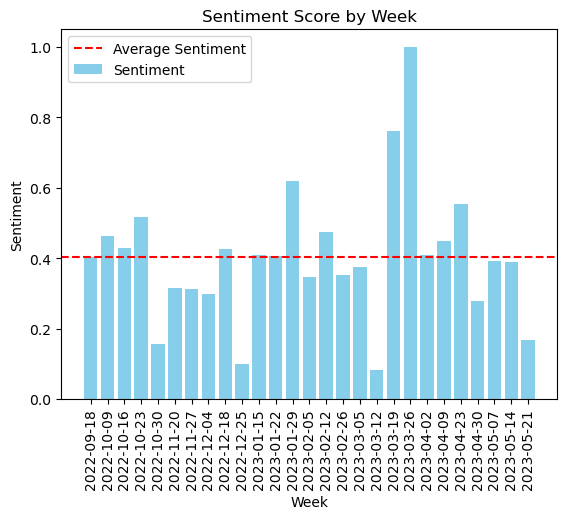

In [313]:
# extracting the date from the 'Week End' column
df_weekly_avg_sentiment['Week End'] = pd.to_datetime(df_weekly_avg_sentiment['Week End']).dt.date

# calculating the average sentiment
avg_sentiment = df_weekly_avg_sentiment['sentiment'].mean()

# ploting the bar chart
X = df_weekly_avg_sentiment['Week End']
X_axis = np.arange(len(X))

plt.bar(X_axis - 0.0, df_weekly_avg_sentiment['sentiment'], 0.8, color='skyblue', label='Sentiment')

# adding horizontal line for the average sentiment value
plt.axhline(y=avg_sentiment, color='red', linestyle='--', label='Average Sentiment')

plt.xticks(X_axis, X)
plt.xticks(rotation=90)

plt.xlabel("Week")
plt.ylabel("Sentiment")
plt.title("Sentiment Score by Week")
plt.legend()
plt.show()

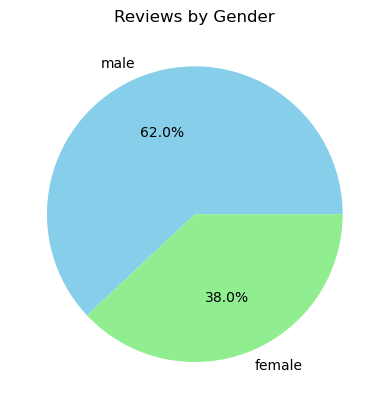

In [291]:
# filtering the DataFrame to exclude 'Unknown' gender
filtered_df = df[df['Gender'] != 'Unknown']

# calculateing the number of reviews by gender
review_counts = filtered_df['Gender'].value_counts()

# creating a pie chart
plt.pie(review_counts, labels=review_counts.index, autopct='%1.1f%%', colors=['skyblue', 'lightgreen'])

# adding title
plt.title('Reviews by Gender')

# displaing the plot
plt.show()

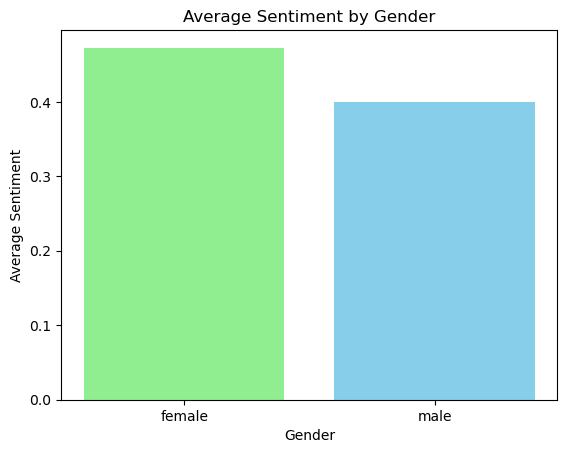

In [314]:
# filtering the DataFrame to exclude 'Unknown' gender
filtered_df = df[df['Gender'] != 'Unknown']

# calculating the average sentiment by gender
average_sentiment = filtered_df.groupby('Gender')['sentiment'].mean()

# creating a bar chart
plt.bar(average_sentiment.index, average_sentiment, color=['lightgreen','skyblue'])

# adding labels and title
plt.xlabel('Gender')
plt.ylabel('Average Sentiment')
plt.title('Average Sentiment by Gender')

# displaing the plot
plt.show()

In [293]:
# converting 'Time' column to datetime type
df['Time'] = pd.to_datetime(df['Time'])

# extracting the hour from the 'Time' column
df['Hour'] = df['Time'].dt.hour

In [294]:
# counting the number of reviews by hour
reviews_by_hour = df.groupby('Hour')['Review'].count()
reviews_by_hour.head()

Hour
1    1
4    2
7    2
8    4
9    4
Name: Review, dtype: int64

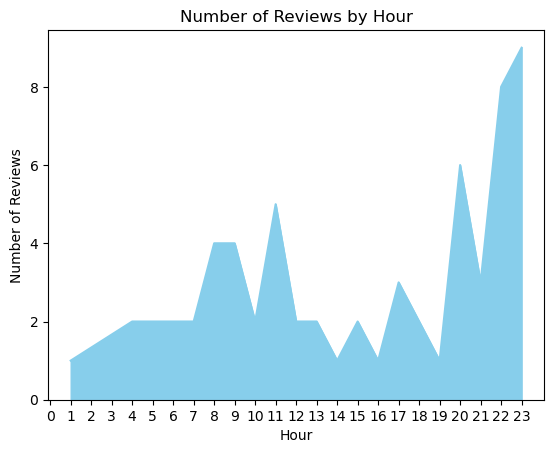

In [295]:
# creating an area chart with skyblue color
reviews_by_hour.plot.area(color='skyblue')

# adding labels and title
plt.xlabel('Hour')
plt.ylabel('Number of Reviews')
plt.title('Number of Reviews by Hour')

# seting x-ticks for each hour
plt.xticks(range(24))

# displaing the plot
plt.show()

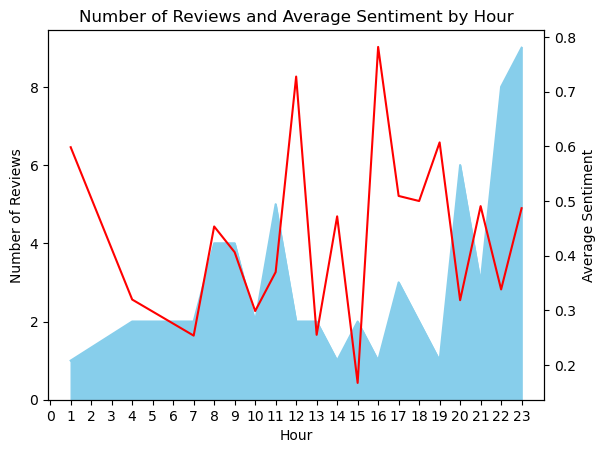

In [296]:
# calculating the average sentiment by hour
avg_sentiment_by_hour = df.groupby('Hour')['sentiment'].mean()

# counting the number of reviews by hour
reviews_by_hour = df.groupby('Hour')['Review'].count()

# creating an area chart with skyblue color
ax1 = reviews_by_hour.plot.area(color='skyblue')
ax1.set_ylabel('Number of Reviews')

# creating a secondary y-axis for average sentiment
ax2 = ax1.twinx()
ax2.plot(avg_sentiment_by_hour.index, avg_sentiment_by_hour, color='red')
ax2.set_ylabel('Average Sentiment')

# adding labels and title
ax1.set_xlabel('Hour')
ax1.set_title('Number of Reviews and Average Sentiment by Hour')

# seting x-ticks for each hour
plt.xticks(range(24))

# displaing the plot
plt.show()

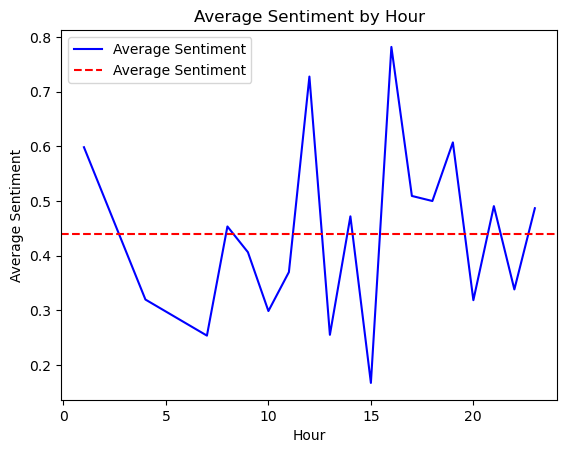

In [297]:
# calculating the average sentiment by hour
avg_sentiment_by_hour = df.groupby('Hour')['sentiment'].mean()

# Ppoting the average sentiment line chart
plt.plot(avg_sentiment_by_hour.index, avg_sentiment_by_hour, color='blue', label='Average Sentiment')

# adding horizontal line for the average sentiment value
avg_sentiment = avg_sentiment_by_hour.mean()
plt.axhline(y=avg_sentiment, color='red', linestyle='--', label='Average Sentiment')

# adding labels and title
plt.xlabel('Hour')
plt.ylabel('Average Sentiment')
plt.title('Average Sentiment by Hour')

# displaing the legend
plt.legend()

# displaing the plot
plt.show()

In [324]:
# sorting df with ascending 
sorted_df = df.sort_values('sentiment', ascending= False)

lowest_sentiment_rows = sorted_df.head(5)

# printing full reviews with the lowest sentiment score
for review in lowest_sentiment_rows['Review']:
    print(review)

Excellent service, delivered promptly with phone call to check goods had been received. Thank you.
Very good coffee. Very happy with my order. I would recommend this company.
Very easy to place an order and delivery was excellent. All done efficiently
Brilliant service, product delivered within 4 days of ordering and a follow up telephone call to check everything was OK!
Excellent service my package arrived 48hours after my order very keenly priced and the product was the one I wanted. A follow up phone call from the company to ensure I was happy was a really nice touch I would use them again well done Murphy Larkin
